### Purpose of this notebook

This notebook estimates the excitation (as photoisomerization rate at the photoreceptor level) that is expected to be caused by the images recorded with the UV/G mouse camera.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Global dictionary
d = dict()

# Global constants
TWILIGHT = 0
DAYLIGHT = 1

UV_S     = 0
UV_M     = 1
G_S      = 2
G_M      = 3

CONE     = 0
ROD      = 1

CHAN_UV  = 0
CHAN_G   = 1

### Approach

When calibrating the mouse camera, we used LEDs of defined wavelength and brightness to map normalized intensity (camera pixel values, 0..1) to power meter readings (see STAR Methods in the manuscript). To relate this power to the photon flux at the cornea and finally the photoisomerisation rate at the photoreceptor level, we need to consider:  

* How much light we loose in the camera, that is, we need the optical paths´ **attenuation factors** from the fisheye lens to the camera chip for the UV ($ \mu_{lens2cam,UV} $) and green ($ \mu_{lens2cam,G} $) channel;  

* The wavelength-specific **transmission of mouse optical aparatus** for UV ($T_{UV}$) and green ($T_G$) light;

* The **ratio between pupil size and retinal area** ($R_{pup2ret}$) to estimate, how much light reaches the retina giving the pupil adapts to the overall brightness of the scene.  

Our approch consists of two main steps:

1. We first map electrical power ($P_{el}$, in $[W]$) to photon flux ($P_{Phi}$, in $[photons/s]$),  

   $$
   P_{Phi}(\lambda) = \frac{P_{el}(\lambda) \cdot a \cdot \lambda \cdot 10^{-9}} {c \cdot h }\cdot \frac{1}{\mu_{lens2cam}(\lambda)}.
   $$  

   For $\lambda$, we use the peak wavelength of the photoreceptor's spectral sensitivity curve ($\lambda_{S}=360 \: nm$, $\lambda_{M}=510 \: nm$). 
   
   The rest are constants ($a=6.2421018 \: eV/J$, $c=299,792,458 \: m/s$, and $h=4.135667 \cdot10^{-15} \: eV \cdot s$).  

2. Next, we convert the photon flux to photoisomerisation rate ($R_{Iso}$, in $[P^*/cone/s]$),

  $$
  R_{Iso}(\lambda) = \frac{P_{Phi}(\lambda)}{A_{Stim}} \cdot A_{Collect} \cdot S_{Act} \cdot T(\lambda) \cdot R_{pup2ret}
  $$

  where $A_{Stim}=10^8 \: \mu m^2$ is area that is iluminated on the power meter sensor, and $A_{Collect}=0.2 \: \mu m^2$ the photoreceptor's outer segment (OS) light collection area (see below).

  With $S_{Act}$ we take into account that the bandpass filters in the camera pathways do not perfectly match these sensitivity spectra (see below).

  > Note: The OS light collection area ($[\mu m^2]$) an experimentally determined value, e.g. for wt mouse cones that are fully dark-adapted, a value of 0.2 is be assumed; for mouse rods, a value of 0.5 is considered realistic (for details, see [Nikonov et al., 2006](http://www.ncbi.nlm.nih.gov/pubmed/16567464)). 

In [2]:
d.update({"ac_um2": [0.2, 0.5], "peak_S": 360, "peak_M": 510, "A_stim_um2": 1e8})

### Attenuation factors of the two camera pathways

We first calculated the attenuation factor from the fisheye lens to the focal plane of the camera chip. 

To this end, we used a spectrometer (STS-UV, Ocean Optics) with an optical fiber (P50-1-UV-VIS) to first measure the spectrum of the sky directly, and then at the camera focal planes of the UV and the green pathways. These readouts, which are spectra, are referred to as $P_{direct}$, $P_{UV}$ and $P_{G}$. 

In [3]:
#%%capture
#!wget -O sky_spectrum.npy https://www.dropbox.com/s/p8uk4k6losfu309/sky_spectrum.npy?dl=0
    
#spect = np.load('sky_spectrum.npy', allow_pickle=True).item() 

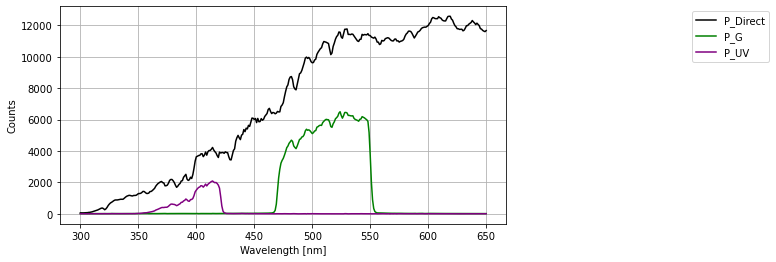

In [4]:
# Load spectra
# The exposure times were 4 s for `direct` and `g`, and 30 s for `uv`
spect = np.load('data/sky_spectrum.npy', allow_pickle=True).item() 

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(8,4))
axes.plot(spect["wavelength"], spect["direct"], color='k', label='P_Direct')
axes.plot(spect["wavelength"], spect["g"], color='g', label='P_G')
axes.plot(spect["wavelength"], spect["uv"], color='purple',label='P_UV')
axes.set_xlabel ("Wavelength [nm]")
axes.set_ylabel("Counts")
axes.grid()
axes.legend(loc='upper right', bbox_to_anchor=(1.6, 1.0))

Since the readout on the objective side (fisheye lens) is related to both visual angle and area, while the readout on the imaging side is only related to area, we define:

$$
\begin{align}
P_{direct} &= P_{total} \cdot \frac{A_{fiber}}{A_{lens}} \cdot \frac{\theta_{fiber}}{\theta_{lens}}\\
P_{UV} &= P_{total} \cdot \frac{A_{fiber}}{A_{chip}} \cdot \mu_{lens2cam,UV}\\
P_{G} &= P_{total} \cdot \frac{A_{fiber}}{A_{chip}} \cdot \mu_{lens2cam,G}
\end{align}
$$  

where $P_{total}$ denotes the total power of the incident light at the fisheye lens, $A_{fiber}$ the area of the fibre, $A_{lens}$ the area of the fisheye lens, $A_{chip}$ the imaging area of the camera chip, and $\theta_{fiber}$ and $\theta_{lens}$ the acceptance angles of fiber and fisheye lens, respectively.  

After rearranging the equations, we get:  

$$
\begin{align}
\mu_{lens2cam,UV} &= \frac{P_{UV}}{P_{direct}} \cdot \frac{A_{chip}}{A_{lens}} \cdot \frac{\theta_{fiber}}{\theta_{lens}}\\
\mu_{lens2cam,G}  &= \frac{P_{G}}{P_{direct}} \cdot \frac{A_{chip}}{A_{lens}} \cdot \frac{\theta_{fiber}}{\theta_{lens}}
\end{align}
$$   

By calculating the ratio between the area under curve (AUC) of the spectrum for the respective chromatic channel (within in the spectral range of the respective bandpass filter) and the AUC of the spectrum for the direct measurement, we get:

$$
\frac{P_{UV}}{P_{direct}} = \frac{1}{21}, \frac{P_{G}}{P_{direct}} = \frac{1}{2}
$$ 

Practically, we also take the different exposure times (4 s for $P_{direct}$ and $P_{G}$, and 30 s for $P_{UV}$) into account.

In [5]:
direct_exp_s = 4
UV_exp_s = 30
G_exp_s = 4 
P_UV2direct = 1/(np.trapz(spect["direct"][350-300:420-300])/np.trapz(spect["uv"][350-300:420-300]) *UV_exp_s/direct_exp_s) 
P_G2direct = 1/(np.trapz(spect["direct"][470-300:550-300])/np.trapz(spect["g"][470-300:550-300]) *G_exp_s/direct_exp_s) 

print("P_UV/P_direct = {0:.3f}".format(P_UV2direct))
print("P_G/P_direct  = {0:.3f}".format(P_G2direct))

P_UV/P_direct = 0.047
P_G/P_direct  = 0.533



The diameters of the camera chip's imaging area and the fisheye lens were $2,185 \: \mu m$ and $15,000 \: \mu m$, respectively. The acception angles of the optical fiber and the fisheye lens were $\theta_{fibre}=24.8^{\circ}$ and $\theta_{lens}=180^{\circ}$, respectively.

In [6]:
A_cam = np.pi*(2185/2)**2
A_lens = np.pi*(15000/2)**2
theta_fiber = 24.8 
theta_lens = 180

Now we can get the attenuation factors $ \mu_{lens2cam,UV} $ and $ \mu_{lens2cam,G} $, covering the optical path from the fisheye lens to the camera chip: 

In [7]:
mu_lens2cam = [0,0]
mu_lens2cam[CHAN_UV] = P_UV2direct *A_cam /A_lens *theta_fiber /theta_lens
mu_lens2cam[CHAN_G] = P_G2direct *A_cam /A_lens * theta_fiber /theta_lens
d.update({"mu_lens2cam": mu_lens2cam})

print("mu_lens2cam for UV,G = {0:.3e}, {1:.3e}".format(mu_lens2cam[CHAN_UV], mu_lens2cam[CHAN_G]))

mu_lens2cam for UV,G = 1.365e-04, 1.557e-03


### Attenuation by mouse eye optics

Another factor we need to consider is the wavelength-dependent attenuation by the mouse eye optics. The relative transmission for UV ($T_{Rel}(UV)$, at $\lambda=360 \: nm$) and green ($T_{Rel}(G)$, at $\lambda=510 \: nm$) is approx. 35% and 55%, respectively ([Henriksson et al., 2010](https://pubmed.ncbi.nlm.nih.gov/19925789/)).

In [8]:
d.update({"T_rel": [0.35, 0.55]})

In addition, the light reaching the retina depends on the ratio ($R_{pup2ret}$) between pupil area and retinal area (both in $[mm^2]$) ([Rhim et al., 2020](https://www.biorxiv.org/content/10.1101/2020.11.03.366682v1)). Here, we assume pupil areas of $0.1 \: mm^2$ (maximally constricted) at daytime and $0.22 \: mm^2$ at twighlight (approx. 10% of full pupil area; see [Pennesi et al., 1998](https://pubmed.ncbi.nlm.nih.gov/9761294/)). To calculate the retinal area of the mouse, we assume an eye axial length of approx. $3 \: mm$ and that the retina covers about 60% of the sphere's surface ([Schmucker & Schaeffel, 2004](https://www.sciencedirect.com/science/article/pii/S0042698904001257#FIG4)).

In [9]:
eye_axial_len_mm = 3
ret_area_mm2 = 0.6 *(eye_axial_len_mm/2)**2 *np.pi *4
pup_area_mm2 = [0.22, 0.1]
R_pup2ret= [x /ret_area_mm2 for x in pup_area_mm2]
d.update({"R_pup2ret": R_pup2ret, "pup_area_mm2": pup_area_mm2, "ret_area_mm2": ret_area_mm2})

print("mouse retinal area [mm²]            = {0:.1f}".format(ret_area_mm2))
print("pupil area         [mm²]            = twilight: {0:.1f} \tdaylight: {1:.1f}".format(pup_area_mm2[TWILIGHT], pup_area_mm2[DAYLIGHT]))
print("ratio of pupil area to retinal area = twilight: {0:.3f} \tdaylight: {1:.3f}".format(R_pup2ret[TWILIGHT],R_pup2ret[DAYLIGHT]))

mouse retinal area [mm²]            = 17.0
pupil area         [mm²]            = twilight: 0.2 	daylight: 0.1
ratio of pupil area to retinal area = twilight: 0.013 	daylight: 0.006


### Cross-activation of S- and M-opsins ...

... by the UV and green camera channels, yielding $S_{Act}(S,UV)$, $S_{Act}(S,G)$, $S_{Act}(M,UV)$, and $S_{Act}(M,G)$.

In [10]:
#%%capture
#!wget -O opsin_filter_spectrum.npy https://www.dropbox.com/s/doh1jjqukdcpvpy/opsin_filter_spectrum.npy?dl=0

#spect = np.load('opsin_filter_spectrum.npy', allow_pickle=True).item() 

S_act UV -> S = 0.625
      UV -> M = 0.118
      G  -> S = 0.000
      G  -> M = 0.858


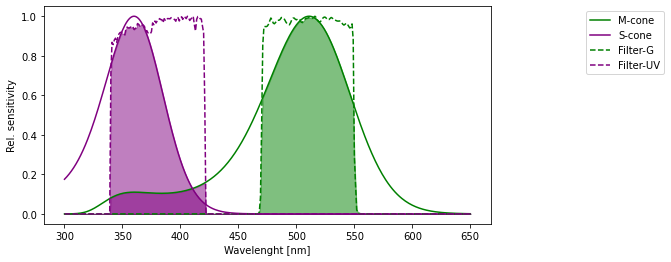

In [11]:
# Load opsin and filter spectra
spect = np.load('data/opsin_filter_spectrum.npy', allow_pickle=True).item() 

wavelength  = spect["wavelength"]
mouseSOpsin = spect["mouseSOpsin"]
mouseMOpsin = spect["mouseMOpsin"]
filter_uv   = spect["filter_uv"]
filter_g    = spect["filter_g"]
filter_uv_scone = np.minimum(filter_uv,mouseSOpsin)
filter_uv_mcone = np.minimum(filter_uv,mouseMOpsin)
filter_g_scone  = np.minimum(filter_g, mouseSOpsin)
filter_g_mcone  = np.minimum(filter_g, mouseMOpsin)

S_act = [0]*4
S_act[UV_S] = np.trapz(filter_uv_scone)/np.trapz(filter_uv)
S_act[UV_M] = np.trapz(filter_uv_mcone)/np.trapz(filter_g)
S_act[G_S]  = np.trapz(filter_g_scone)/np.trapz(filter_uv)
S_act[G_M]  = np.trapz(filter_g_mcone)/np.trapz(filter_g)
d.update({"S_act": S_act})

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(8,4))
axes.plot(wavelength,mouseMOpsin,color='g',     linestyle='-',label='M-cone')
axes.plot(wavelength,mouseSOpsin,color='purple',linestyle='-',label='S-cone')
axes.plot(wavelength,filter_g, color='g',       linestyle='--',label='Filter-G')
axes.plot(wavelength,filter_uv,color='purple',  linestyle='--',label='Filter-UV')
axes.fill_between(wavelength,y1=filter_g_mcone, y2=0,color='g',     alpha=0.5)
axes.fill_between(wavelength,y1=filter_g_scone, y2=0,color='g',     alpha=0.5)
axes.fill_between(wavelength,y1=filter_uv_mcone,y2=0,color='purple',alpha=0.5)
axes.fill_between(wavelength,y1=filter_uv_scone,y2=0,color='purple',alpha=0.5)
axes.set_xlabel ("Wavelenght [nm]")
axes.set_ylabel("Rel. sensitivity")
axes.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))

print("S_act UV -> S = {0:.3f}".format(S_act[UV_S]))
print("      UV -> M = {0:.3f}".format(S_act[UV_M]))
print("      G  -> S = {0:.3f}".format(S_act[G_S]))
print("      G  -> M = {0:.3f}".format(S_act[G_M]))

### Estimating photoisomerization rates

The following function converts normalized image intensities (0...1) to $P_{el}(\lambda)$ (in $[\mu W]$), $P_{Phi}(\lambda)$ (in $[photons /s]$), and $R_{Iso}(\lambda)$ (in $[P^*/cone/s]$).


In [12]:
def inten2Riso(intensities, pup_area_mm2, pr_type=CONE):
    """
    Transfer the normalized image intensities (0...1) to power (unit: uW), 
    photon flux (unit: photons/s) and photoisomerisation rate (P*/cone/s)

    Input:
    intensities    : image intensities (0...1) for both channels as tuple
    pup_area_mm2   : pupil area in mm^2

    Output:
    P_el           : tuple (CHAN_UV, CHAN_G) 
    P_Phi          : tuple (CHAN_UV, CHAN_G) 
    R_Iso          : tuple (UV_S, UV_M, G_S, G_M)
    """
    global d

    h = 4.135667e-15          # Planck's constant [eV*s]
    c = 299792458             # speed of light [m/s]
    eV_per_J = 6.242e+18      # [eV] per [J]
  
    # Convert normalized image intensities (0...1) to power ([uW])
    # (Constants from camera calibration, see STAR Methods for details)
    P_el = [0]*2
    P_el[CHAN_UV] = intensities[CHAN_UV] *0.755 +0.0049
    P_el[CHAN_G]  = intensities[CHAN_G] *6.550 +0.0097  

    # Convert electrical power ([uW]) to photon flux ([photons/s])
    P_Phi = [0]*2
    P_Phi[CHAN_UV] = (P_el[CHAN_UV] *1e-6) *eV_per_J *(d["peak_S"]*1e-9)/(c*h) *(1/d["mu_lens2cam"][CHAN_UV])
    P_Phi[CHAN_G]  = (P_el[CHAN_G] *1e-6) *eV_per_J *(d["peak_M"]*1e-9)/(c*h) *(1/d["mu_lens2cam"][CHAN_G])

    # Convert photon flux ([photons/s]) to photoisomerisation rate ([P*/cone/s])
    R_pup2ret = pup_area_mm2 /d["ret_area_mm2"]
    R_Iso = [0]*4
    for j in [UV_S, UV_M, G_S, G_M]:
      chan = CHAN_UV if j < G_S else CHAN_G 
      R_Iso[j] = P_Phi[chan] /d["A_stim_um2"] *d["ac_um2"][pr_type]* d["S_act"][j] *d["T_rel"][chan] *R_pup2ret

    return P_el, P_Phi, R_Iso

Example `[[0.18, 0.11], [0.06, 0.14]]`, with the following format `[upper[UV,G],lower[UV,G]]`

In [13]:
intensities=[[0.18, 0.11], [0.06, 0.14]]
for j, i in enumerate(intensities):
  l = inten2Riso(i, 0.2)
  print("{0:2d} (UV, G) P_el = {1:.3f}, {2:.3f}\t P_Phi = {3:.1e}, {4:.1e} ".format(j, l[0][0], l[0][1], l[1][0], l[1][1]))
  print("   UV->S = {0:.1e} \t UV->M = {1:.1e} \t G->S = {2:.1e} \t G->M = {3:.1e}".format(l[2][0], l[2][1], l[2][2], l[2][3]))


 0 (UV, G) P_el = 0.141, 0.730	 P_Phi = 1.9e+15, 1.2e+15 
   UV->S = 9.6e+03 	 UV->M = 1.8e+03 	 G->S = 7.0e-01 	 G->M = 1.3e+04
 1 (UV, G) P_el = 0.050, 0.927	 P_Phi = 6.7e+14, 1.5e+15 
   UV->S = 3.4e+03 	 UV->M = 6.5e+02 	 G->S = 8.8e-01 	 G->M = 1.7e+04


### Generate Supplementary Table 1

In [14]:
col_names = ['Mean intensity<br>group', 'Visual<br>field', 'Camera<br>channel', 'Norm.<br>intensity', 'P_el<br>in [µW]',\
           'P_Phi<br>in [photons/s]', 'Pupil area<br>in [mm2]',\
           'R_Iso<br>in [P*/cone/s], S', 'R_Iso<br>in [P*/cone/s], M', 'R_Iso<br>in [P*/rod/s], rod']

data_df  = pd.DataFrame(columns = col_names)

group = ['Low', 'Medium', 'High', 'Twilight']
group = [item for item in group for i in range(4)]
data_df['Mean intensity<br>group'] = group

visual_field=['Upper', 'Upper', 'Lower', 'Lower']*4
data_df['Visual<br>field'] = visual_field

camera_channel=['UV', 'G']*8
data_df['Camera<br>channel'] = camera_channel

norm_intensity = [0.18, 0.11, 0.06, 0.14, 0.28, 0.16, 0.09, 0.21, 0.50, 0.34, 0.22, 0.46, 0.05, 0.06, 0.02, 0.05]
data_df['Norm.<br>intensity'] = norm_intensity

# Pupil area
data_df['Pupil area<br>in [mm2]'] = np.where(data_df['Mean intensity<br>group'] == 'Twilight', \
                                          d['pup_area_mm2'][TWILIGHT], d['pup_area_mm2'][DAYLIGHT])

# Photoisomerisations
for ii in range(int(len(data_df.index)/2)):
  tempUV, tempG = data_df.iloc[ii*2, 3], data_df.iloc[ii*2+1, 3]
  templ = inten2Riso([tempUV, tempG], data_df.iloc[ii*2, 6])
  data_df.iloc[ii*2, 4], data_df.iloc[ii*2+1, 4] = templ[0][0], templ[0][1]
  data_df.iloc[ii*2, 5], data_df.iloc[ii*2+1, 5] = templ[1][0], templ[1][1]
  data_df.iloc[ii*2,7], data_df.iloc[ii*2,8], data_df.iloc[ii*2+1,7], data_df.iloc[ii*2+1,8] =\
                                          templ[2][0], templ[2][1], templ[2][2], templ[2][3]
  templ = inten2Riso([tempUV,tempG], data_df.iloc[ii*2, 6], pr_type=ROD)      
  data_df.iloc[ii*2,9] = templ[2][1]                                 
  data_df.iloc[ii*2+1,9] = templ[2][3]

# Show table
'''
# Set colormap equal to seaborns light green color palette
cmG = sns.light_palette("green", n_colors=50, as_cmap=True, reverse=False)
cmUV = sns.light_palette("purple", n_colors=50, as_cmap=True, reverse=False)

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '14px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

(data_df.style
  .background_gradient(cmap=cmUV, subset=['R_Iso<br>in [P*/cone/s], S'])
  .background_gradient(cmap=cmG, subset=['R_Iso<br>in [P*/cone/s], M'])
  .background_gradient(cmap=cmG, subset=['R_Iso<br>in [P*/rod/s], rod'])
  #.highlight_max(subset=['R_Iso<br>in [P*/cone/s], S','R_Iso<br>in [P*/cone/s], M'])
  .format({"Norm.<br>intensity": "{:.2f}","P_el<br>in [µW]": "{:.3f}", 
           "P_Phi<br>in [photons/s]": "{:.3e}", "Pupil area<br>in [mm2]": "{:.1f}",
           "R_Iso<br>in [P*/cone/s], S": "{:.0f}", 
           "R_Iso<br>in [P*/cone/s], M": "{:.0f}",
           "R_Iso<br>in [P*/rod/s], rod": "{:.0f}"})
  .set_table_styles(styles)
  .set_properties(**{'white-space': 'pre-wrap',}))
'''
display(data_df)

,Mean intensity<br>group,Visual<br>field,Camera<br>channel,Norm.<br>intensity,P_el<br>in [µW],P_Phi<br>in [photons/s],Pupil area<br>in [mm2],"R_Iso<br>in [P*/cone/s], S","R_Iso<br>in [P*/cone/s], M","R_Iso<br>in [P*/rod/s], rod"
0,Low,Upper,UV,0.18,0.1408,1.86905e+15,0.10,4816.84,907.875,2269.69
1,Low,Upper,G,0.11,0.7302,1.2039e+15,0.10,0.348107,6700.09,16750.2
2,Low,Lower,UV,0.06,0.0502,6.66379e+14,0.10,1717.37,323.688,809.221
3,Low,Lower,G,0.14,0.9267,1.52787e+15,0.10,0.441784,8503.12,21257.8
4,Medium,Upper,UV,0.28,0.2163,2.87127e+15,0.10,7399.74,1394.7,3486.74
5,Medium,Upper,G,0.16,1.0577,1.74386e+15,0.10,0.504235,9705.13,24262.8
6,Medium,Lower,UV,0.09,0.07285,9.67046e+14,0.10,2492.24,469.735,1174.34
7,Medium,Lower,G,0.21,1.3852,2.28381e+15,0.10,0.660364,12710.2,31775.4
8,High,Upper,UV,0.50,0.3824,5.07616e+15,0.10,13082.1,2465.7,6164.26
9,High,Upper,G,0.34,2.2367,3.6877e+15,0.10,1.0663,20523.3,51308.2
